# Fig 4: Analysis of GP output and structure of growth variation

This notebook is used to analyze the Gaussian process output from the file `gp_pipeline.jl`
including the MSD analysis

# Setup and load data

In [217]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools
cd(dirname(@__FILE__))

## Load experimental data

11824-element Vector{Float64}:
 12.0
 12.0
 12.0
 12.0
 12.0
 12.0
 12.0
 12.0
 12.0
 12.0
  ⋮
  8.0
  8.0
  8.0
  8.0
  8.0
  8.0
  8.0
  8.0
  8.0

In [301]:
# raw data
data_raw = CSV.read("./../output/data_processed.csv",DataFrames.DataFrame);

data_gp = CSV.read("./../output/gp_8-30-24/preds.csv",DataFrame)
lineages = unique(data_gp.lineage);
lengths = vcat([
    length(
        unique(data_gp[data_gp.lineage .== lineages[i],:position])
        ) .*
    ones(
        length(
            data_gp[data_gp.lineage .== lineages[i],:time]
            )
        ) 
    for i in eachindex(lineages)]...)
data_gp[:,:length] = lengths
data_gp = data_gp[data_gp.length .>10,:]
lineages = unique(data_gp.lineage);
lineages

7-element Vector{Float64}:
  1.0
  2.0
  4.0
  5.0
  6.0
 14.0
 22.0

# High-level visualization of output

## Consistency with raw data

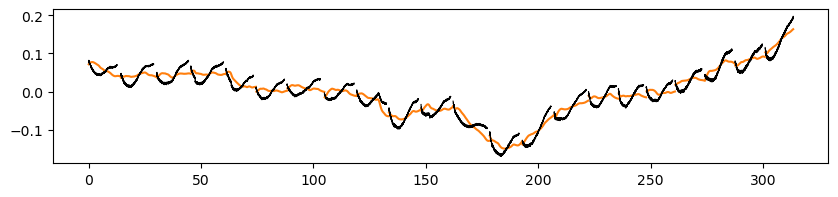

In [231]:
fig,ax = subplots(figsize=(10,2))
k = 4

dr = data_raw[data_raw.lineage .== lineages[k],:]
dr = dr[dr.cellcycle .== "i",:]
dr.time = dr.time .- dr.time[1]
y = dr.lnM_sum 
t = dr.time
dr[:,:z] = y .- cov(y,t)/var(t) .*t
dr[:,:z] = dr.z .- mean(dr.z)

pred = data_gp[data_gp.lineage .== lineages[k],:]
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)
    d = pred[pred.position .==p,:]
    #ax.plot(d.time,d.matern32_cell_x,"C0-")
    ax.plot(d.time,d.matern32_flucs,"C1-")
    d = dr[dr.position .==p,:]
    ax.plot(d.time,d.z,"k-",lw=0.8)

end
fig

## Relative size of terms in decomposition

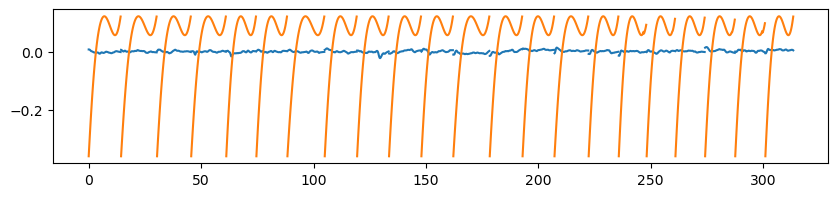

In [232]:
fig,ax = subplots(figsize=(10,2))
#ax.plot(preds[k].time,preds[k].matern32_flucs_x)
for p in unique(pred.position)
    d = pred
    ax.plot(d[d.position .== p,:].time,d[d.position .== p,:].matern32_flucs_x,"C0-")
    ax.plot(d[d.position .== p,:].time,d[d.position .== p,:].matern32_cell_x ,"C1-")
end
fig

# Characterization of fluctuations

## Cell-cycle trend (D)

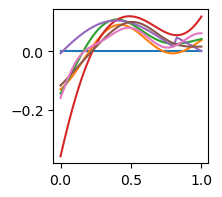

In [233]:


fig, ax= subplots(figsize=(2,2))
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    pred = pred[pred.position .==1,:]
    an = pred.time .- pred.time[1]
    an = an ./ an[end]
    ax.plot(an,pred.matern32_cell_x)
end
fig

## Autocorrelations (E)

## Variance vs. cell-cycle (F)

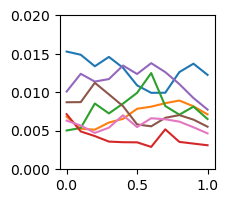

In [239]:


fig, ax= subplots(figsize=(2,2))
for lin in lineages
    pred = data_gp[data_gp.lineage .== lin,:]
    if length(unique(pred.position))>6
        pred = combine(groupby(pred,:position),:time => (x -> x .- x[1]) => :age,:time => (x -> (x .- x[1]) ./ (x[end] - x[1])) => :age_normed,names(pred))
        pred[:,:age_normed] = round.(pred.age_normed,digits=1)
        vdf = combine(groupby(pred,:age_normed),:matern32_flucs_x => std => :v)
        sort!(vdf,:age_normed)
        ax.plot(vdf.age_normed,vdf.v,"-")
    end
end
ax.set_ylim([0,0.02])
fig


# Prediction of variance of cell-cycle averaged growth

In [281]:
unique(data_gp.lineage)

24-element Vector{Float64}:
  1.0
  2.0
  3.0
  4.0
  5.0
  6.0
  7.0
  8.0
  9.0
 10.0
  ⋮
 16.0
 17.0
 18.0
 19.0
 20.0
 21.0
 22.0
 23.0
 24.0

## Setup

In [304]:
data_cells = combine(groupby(data_gp,[:lineage,:position]),
    :matern32_flucs_x=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);

# get time interval for predicted arrays
dt = mean(diff(data_gp[data_gp.lineage .== lineages[1],:time])); 

sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims_cells = combine(groupby(sims,[:lineage,:replicate,:position]),
    :λ=>mean=>:gr,
    :time=>(x->x[end]-x[1])=>:gt);
unique(data_cells.lineage)

7-element Vector{Float64}:
  1.0
  2.0
  4.0
  5.0
  6.0
 14.0
 22.0

## Fitting and simulations

In [305]:
var_df_sims = combine(groupby(sims_cells,[:lineage,:replicate]),:gr=> var => :gr_var)
var_df_data = combine(groupby(data_cells,:lineage),:gr=> var => :gr_var);

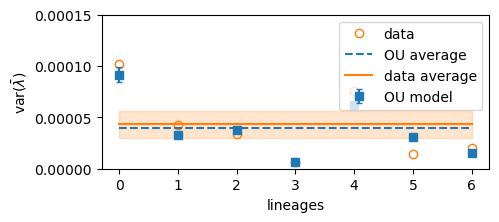

In [306]:

fig, ax= subplots(figsize=(5,2))
sims_means = combine(groupby(var_df_sims,:lineage),:gr_var => mean => :gr_var_avg).gr_var_avg
sims_std = combine(groupby(var_df_sims,:lineage),:gr_var => std => :gr_var_std).gr_var_std ./ sqrt(nreps)

ax.plot(var_df_data.gr_var,"C1o",label="data",fillstyle="none")
ax.errorbar(0:(length(lineages)-1),sims_means,yerr=sims_std,label="OU model",capsize=2,marker="s",color="C0",linestyle="none")
ax.plot(ones(length(var_data)) .* mean(sims_means),"C0--",label="OU average")
ax.plot(ones(length(var_data)) .* mean(var_data),"C1-",label="data average")
ax.fill_between(0:(length(lineages)-1),ones(length(var_data)) .* mean(var_data) .-  std(var_data)/sqrt(length(lineages)), 
ones(length(var_data)) .* mean(var_data) .+  std(var_data)/sqrt(length(lineages)),alpha=0.2,color="C1")
ax.legend(frameon=true)
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$")
ax.set_xlabel("lineages")
ax.set_ylim([0,0.00015])
savefig("./../figures/OU_vs_data.pdf",bbox_inches="tight")
fig


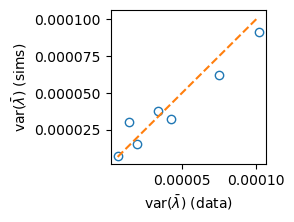

In [320]:
fig, ax= subplots(figsize=(2,2))
ax.plot(var_df_data.gr_var,sims_means,"o",fillstyle="none")
ax.plot(sort(var_df_data.gr_var),sort(var_df_data.gr_var),"--")
ax.set_xlabel(L"${\rm var}(\bar{\lambda})$ (data)")
ax.set_ylabel(L"${\rm var}(\bar{\lambda})$ (sims)")
fig

# Tests

# Misc

In [390]:
sims = CSV.read("./../output/sims_OUfit.csv",DataFrame);
sims[:,:lnM] = log.(sims[:,:M])
lineages = unique(sims.lineage)
replicates= unique(sims.replicate)


dfs = []
for l in lineages
    for r in replicates
        y =0.
        lnM_sums = []
        d = sims[(sims.lineage .==l) .& (sims.replicate .== r),:]
        for p in unique(d.position)
            Z = sort(d[d.position .==p,:],:time).lnM
            Z = Z .- Z[1] .+ y .+ mean(diff(Z))
            push!(lnM_sums,Z)
            y = Z[end]
        end
        lnM_sum = vcat(lnM_sums...);
        d[:,:lnM_sum] = lnM_sum
        push!(dfs,d)
    end
end
sims = vcat(dfs...);



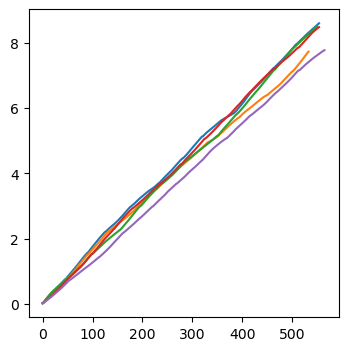

In [393]:
fig, ax = subplots(figsize=(4,4))
for r in replicates
    d = sims[(sims.lineage .==lineages[1]) .& (sims.replicate .== r),:]
    ax.plot(d.lnM_sum,"-")
end
fig

In [346]:
sim

UndefVarError: UndefVarError: `sim` not defined